# Exploration and Comparison of Transformers for Image Classification

## Zero-Shot Transfer using CLIP


### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('..')

import torch
import torch.nn as nn

from transformers import CLIPImageProcessor, CLIPTokenizer
from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import CLIP
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

### Model

Load pre-trained CLIP model.

In [5]:
model = CLIP()

Print the number of parameters.

In [6]:
get_model_params(model)

Parameters: 149.62M


Load CLIP image processor and tokenizer used for image and text pre-processing.

In [7]:
processor, tokenizer = get_clip_processor_and_tokenizer()

### Data Preprocessing

Load each dataset and clean its labels.

CLIP's processor and tokenizer is automatically applied to images and corresponding texts.

Since this is a zero-shot transfer experiment, only the test/validation split is needed.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45 = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
resisc45.dataset

Dataset({
    features: ['image', 'label', 'image_id'],
    num_rows: 6300
})

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101 = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
food101.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 25250
})

#### FER2013

In [10]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013 = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
fer2013.dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 3589
})

#### PCam

In [11]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
pcam.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32768
})

#### SUN397

In [12]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397 = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
sun397.dataset

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 21750
})

#### Country211

In [13]:
country211 = load_dataset('nateraw/country211')
clean_labels(country211, name='country211')
country211 = ImageDataset(
    dataset=country211['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
country211.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 21100
})

#### DTD

In [14]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}"
)
dtd.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1880
})

### Config

Create a config for experiments and print its settings.

In [15]:
config = Config()
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 5e-05,
 'num_epochs': 5,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0.0001}

Create empty array to store dataset accuracies for each experiment.

In [58]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
country211_accs = []
dtd_accs = []

### Experiment #1 - no prompt

This experiment involes only using class label as text input.

#### RESISC45

In [17]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [01:22<00:00,  9.58it/s]

Zero-shot evaluation completed: loss: 1.6377 | acc: 0.5438


In [59]:
resisc45_accs.append(resisc45_acc)

In [19]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9867549668874173),
 ('golf course', 0.9836065573770492),
 ('baseball diamond', 0.943089430894309),
 ('mobile home park', 0.926829268292683),
 ('rectangular farmland', 0.9111111111111111)]

In [20]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('meadow', 0.0),
 ('terrace', 0.0),
 ('snowberg', 0.031446540880503145),
 ('overpass', 0.08)]

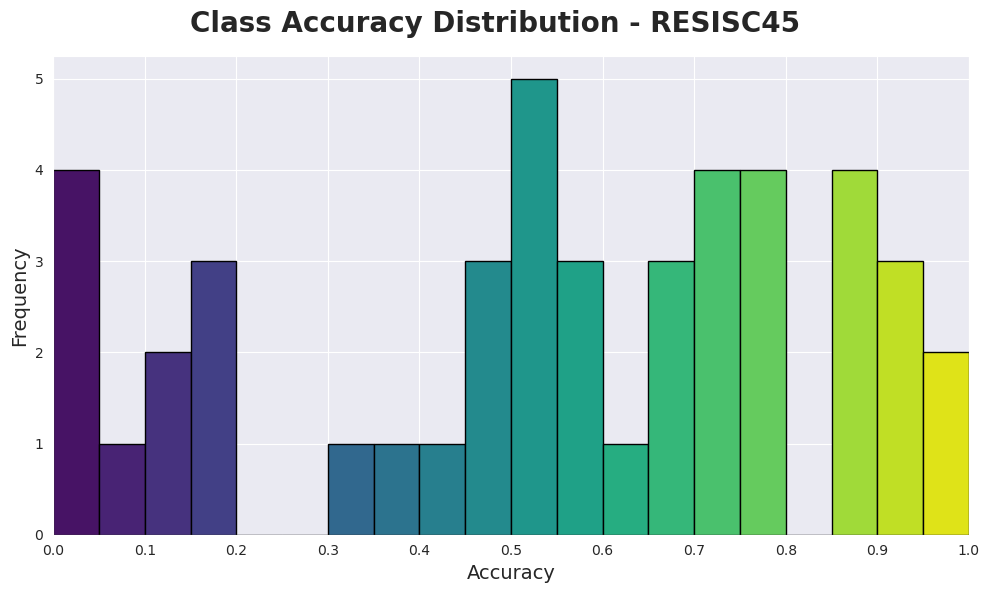

In [21]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

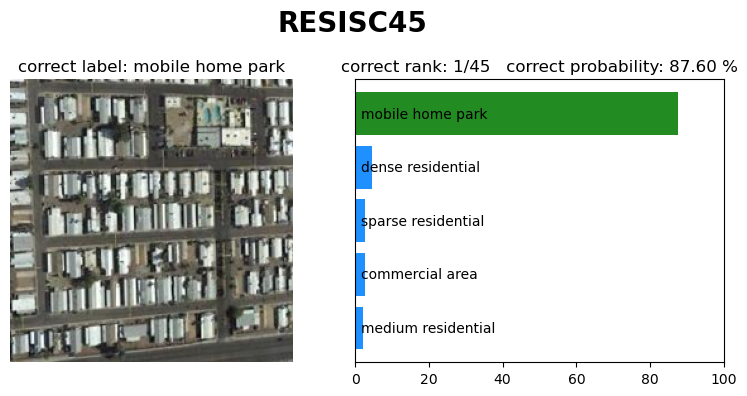

In [22]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [23]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 475/3157 [01:03<05:58,  7.49it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [07:03<00:00,  7.46it/s]


Zero-shot evaluation completed: loss: 0.4645 | acc: 0.8668


In [60]:
food101_accs.append(food101_acc)

In [25]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('lobster roll sandwich', 0.992),
 ('seaweed salad', 0.992),
 ('oysters', 0.984),
 ('macarons', 0.976)]

In [26]:
get_bottom_5_accuracies(food101_per_class_acc)

[('ravioli', 0.164),
 ('steak', 0.508),
 ('hamburger', 0.66),
 ('tacos', 0.664),
 ('pork chop', 0.672)]

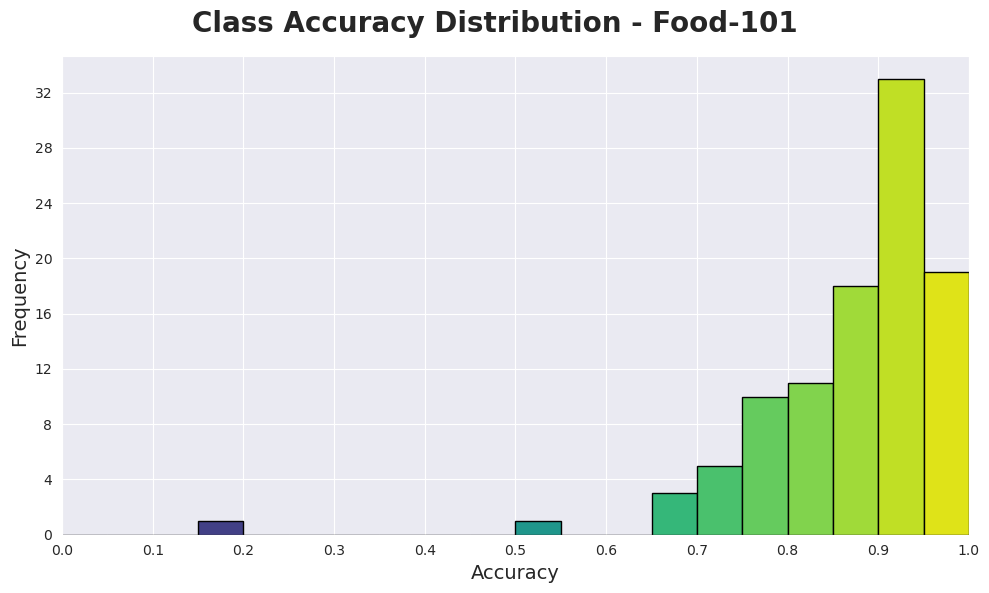

In [27]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

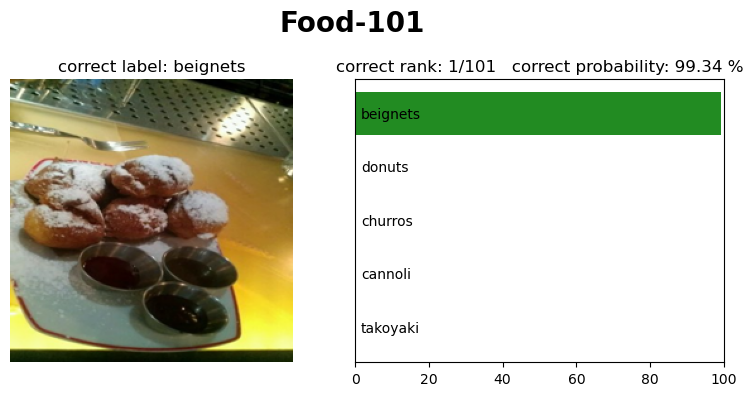

In [28]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [29]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:41<00:00, 10.86it/s]

Zero-shot evaluation completed: loss: 1.8621 | acc: 0.4085


In [61]:
fer2013_accs.append(fer2013_acc)

In [31]:
fer2013_per_class_acc

{'angry': 0.8574338085539714,
 'disgust': 0.21818181818181817,
 'fear': 0.09659090909090909,
 'happy': 0.8714448236632537,
 'sad': 0.03198653198653199,
 'surprise': 0.46634615384615385,
 'neutral': 0.004792332268370607}

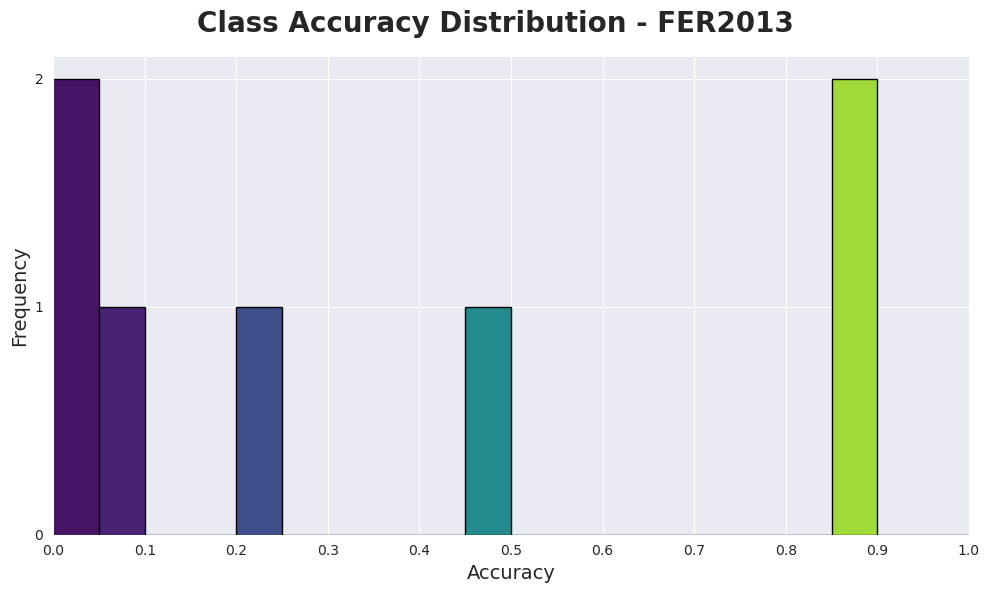

In [32]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

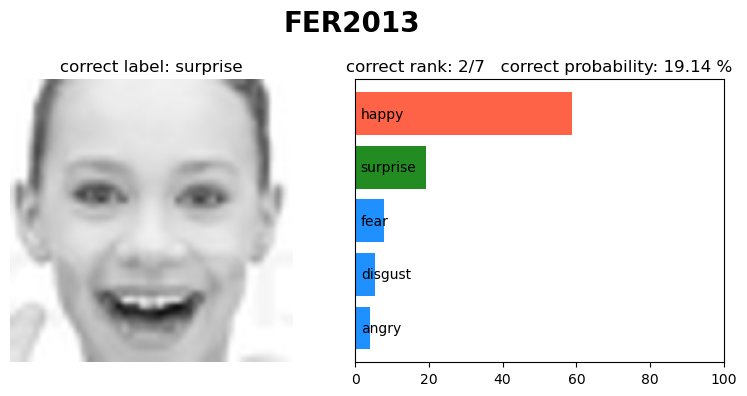

In [33]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [34]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [06:19<00:00, 10.80it/s]

Zero-shot evaluation completed: loss: 0.6905 | acc: 0.5586


In [62]:
pcam_accs.append(pcam_acc)

In [36]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.5089988408272833,
 'lymph node tumor tissue': 0.6082310557489161}

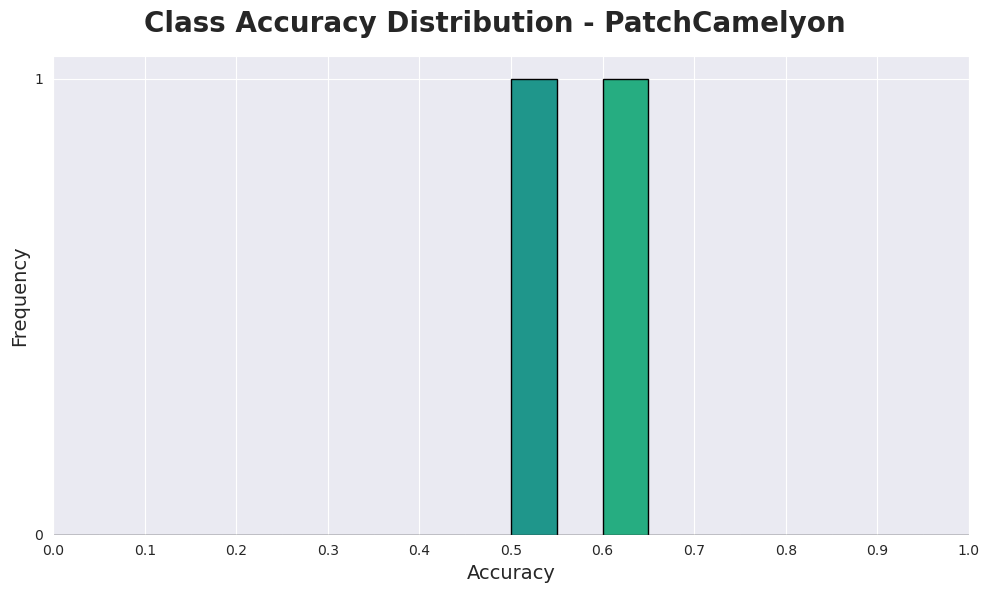

In [37]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

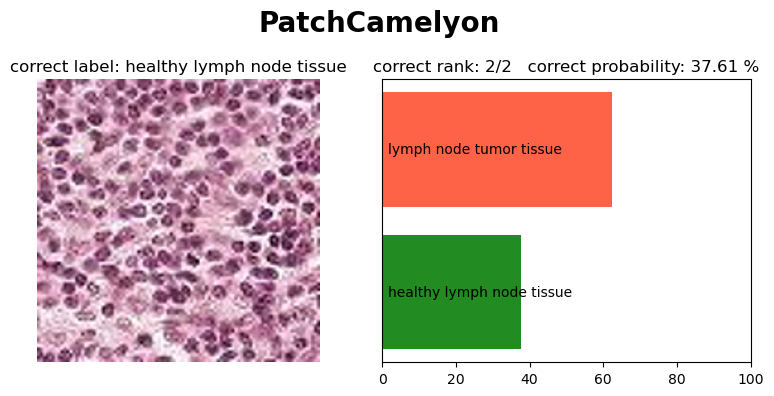

In [38]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [39]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [08:46<00:00,  5.17it/s]


Zero-shot evaluation completed: loss: 1.5255 | acc: 0.6000


In [63]:
sun397_accs.append(sun397_acc)

In [41]:
get_top_5_accuracies(sun397_per_class_acc)

[('heliport', 1.0),
 ('kindergarden classroom', 1.0),
 ('raceway', 1.0),
 ('rock arch', 1.0),
 ('skatepark', 1.0)]

In [42]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('batroom', 0.0),
 ('bazaar (outdoor)', 0.0),
 ('berth', 0.0),
 ('clean room', 0.0),
 ('conference center', 0.0)]

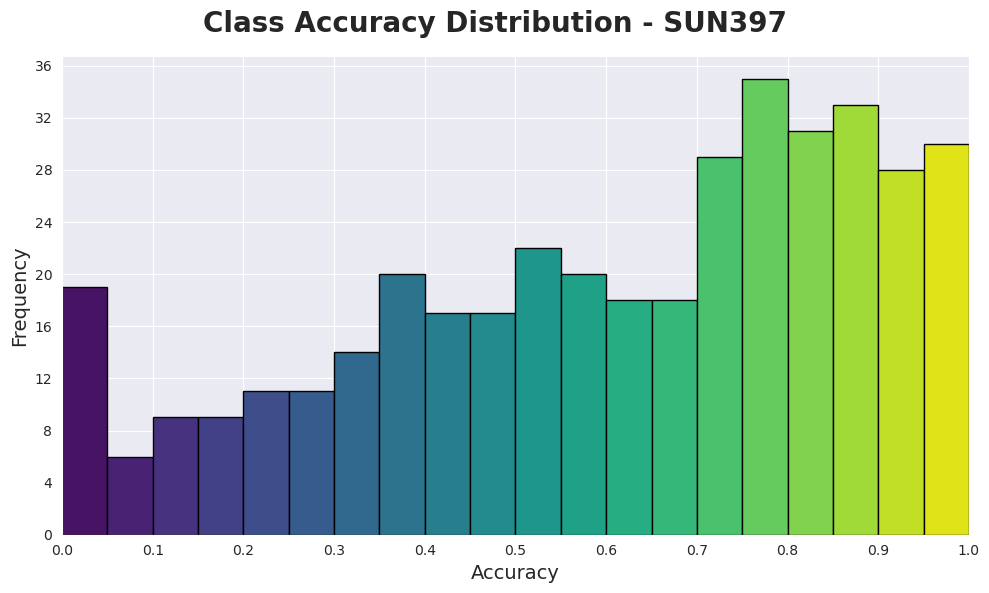

In [43]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

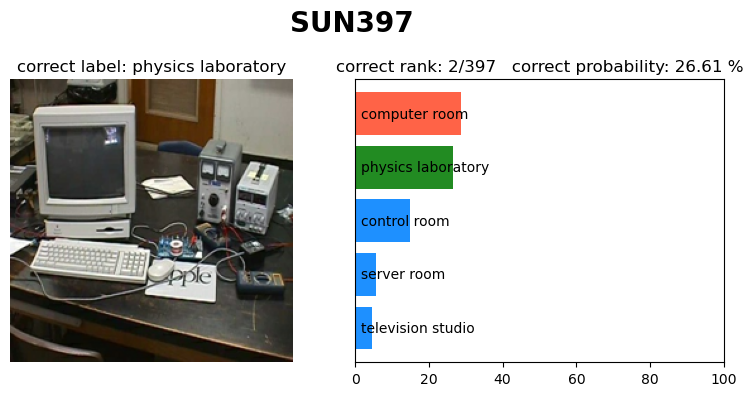

In [44]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### Country211

In [45]:
country211_loss, country211_acc, country211_per_class_acc = evaluate_model(
    model,
    country211,
    config,
    zero_shot=True
)

100%|██████████| 2638/2638 [07:40<00:00,  5.73it/s]


Zero-shot evaluation completed: loss: 3.7837 | acc: 0.1882


In [64]:
country211_accs.append(country211_acc)

In [47]:
get_top_5_accuracies(country211_per_class_acc)

[('Cambodia', 0.66),
 ('Bhutan', 0.65),
 ('South Sudan', 0.65),
 ('Falkland Islands (Malvinas)', 0.64),
 ('Andorra', 0.59)]

In [48]:
get_bottom_5_accuracies(country211_per_class_acc)

[('Gabon', 0.0),
 ('Georgia', 0.0),
 ('Mali', 0.0),
 ('Antigua and Barbuda', 0.01),
 ('Angola', 0.01)]

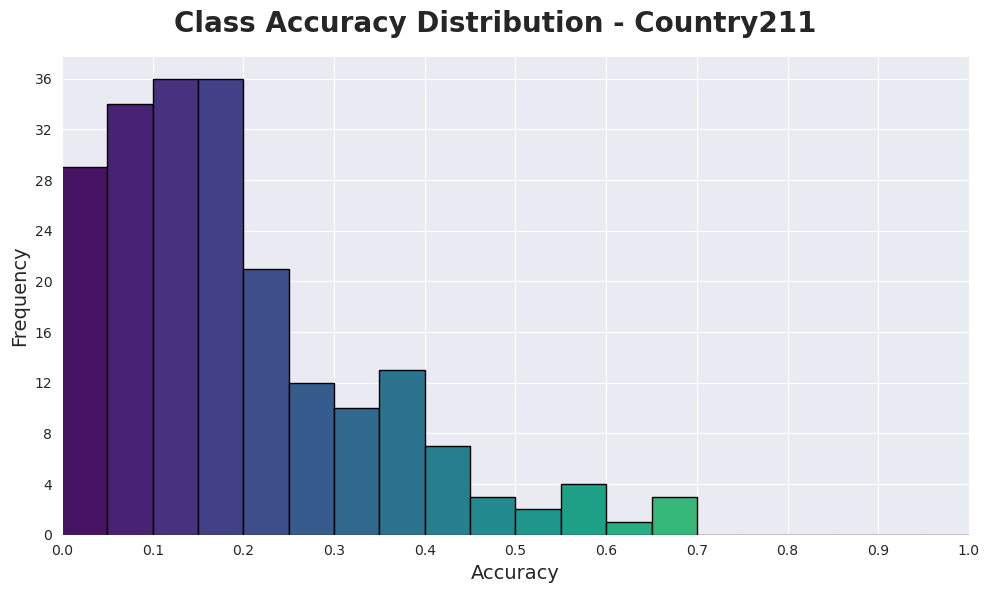

In [49]:
plot_per_class_accuracies(
    country211_per_class_acc,
    'Country211',
    num_bins=20
)

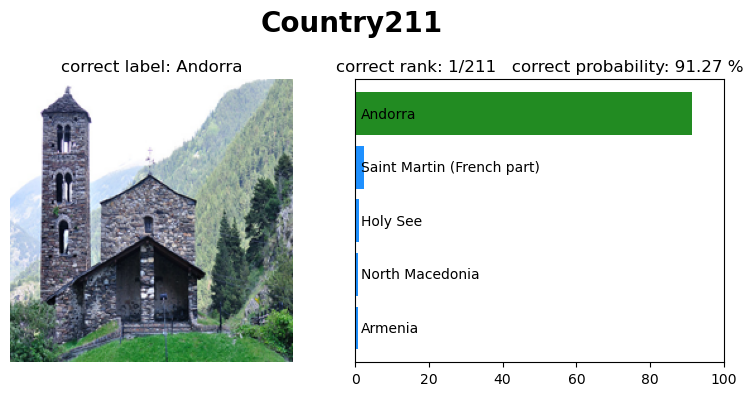

In [50]:
visualize_zero_shot_predict(
    model=model, 
    image=country211.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=country211.get_captions(),
    labels=country211.get_labels(),
    label=country211.get_label(id),
    prompt=country211.get_prompt(),
    title='Country211',
    config=config
)

#### DTD

In [51]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:28<00:00,  8.11it/s]

Zero-shot evaluation completed: loss: 2.2438 | acc: 0.4473


In [65]:
dtd_accs.append(dtd_acc)

In [53]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 0.975),
 ('cobwebbed', 0.975),
 ('crystalline', 0.975),
 ('paisley', 0.975),
 ('marbled', 0.9)]

In [54]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('banded', 0.0),
 ('bumpy', 0.0),
 ('flecked', 0.0),
 ('lacelike', 0.0),
 ('pitted', 0.0)]

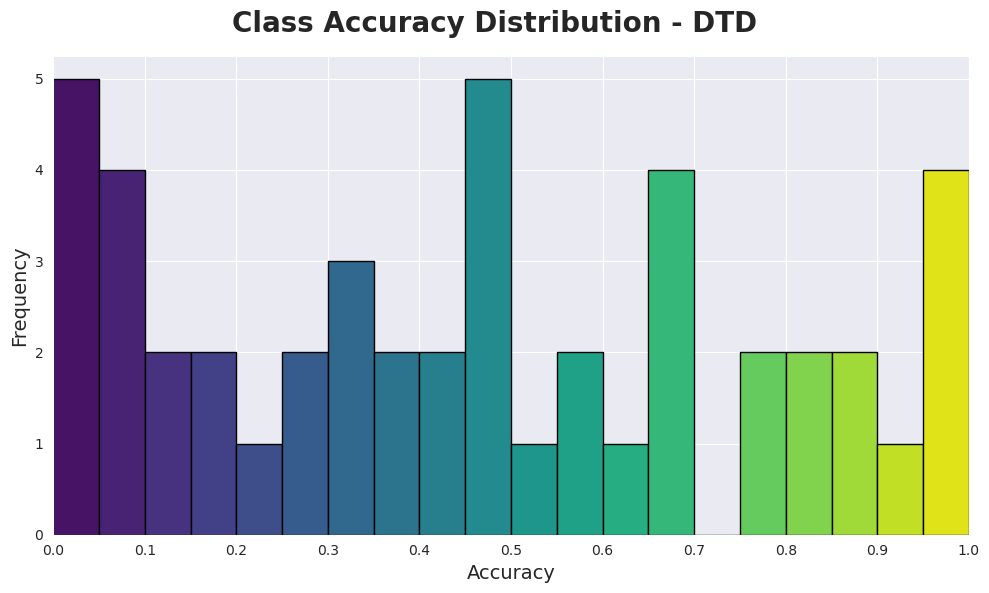

In [55]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

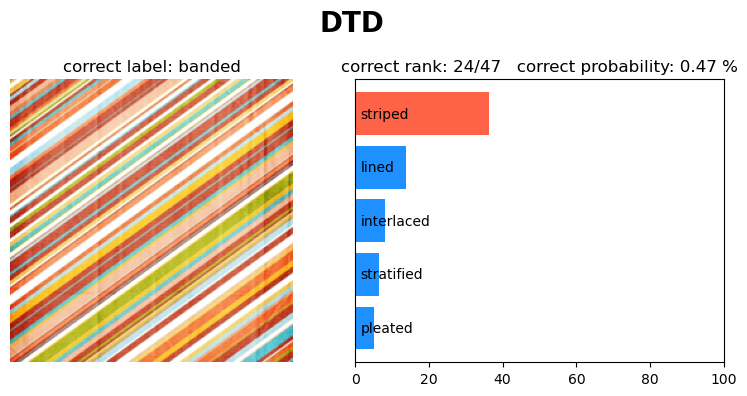

In [56]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)